# HARDER Coding version - M2_Exercises - Geospatial Data Carpentry

For this Exercise, you will build on what you have learned of geospatial data and your previous data carpentry skills to acquire, stage, ingest, and render various datasets.

We will be accessing data linked at the US Government's Geospatial Platform: https://www.geoplatform.gov/


All the datasets will be in different formats. Some you may have seen, some will be new.
 * [New Mexico Populated Places (GNIS), 2009](https://web.dsa.missouri.edu/static/data/geodata/gnis_nm_populated_place.zip)
 * [Bureau of Land Management Land Grant Boundaries](https://web.dsa.missouri.edu/static/data/geodata/land_grants.original.zip)
 * https://web.dsa.missouri.edu/static/data/geodata/school_district_boundaries.derived.gml
 * https://web.dsa.missouri.edu/static/data/geodata/gpsrdsddshp.derived.kml

 
These datasets, while discoverable on geoplatform.gov have been hosted locally on Missouri servers to reduce the risk of the data not being available. 

## Exercise Prerequisite
In the module 2 practices, you ingested the first two data sources into PostGIS.
This is necessary for the completion of this exercise, as you will ingest additional files and then execute Geospatial queries against the ingested data.

# File 1: Geography Markup Format (GML) format

 * https://web.dsa.missouri.edu/static/data/geodata/school_district_boundaries.derived.gml

This file is a GML formatted file of school district boundaries.

Read about the GML format here: https://en.wikipedia.org/wiki/Geography_Markup_Language


Acquire and stage the GML into the `../temp/` folder as you did in the practices.


In [2]:
import os
import urllib.request
import shutil
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

### Task: Acquire the File

In [3]:
## ----- Add Acquisition Code Below -----------
file_URL = 'https://web.dsa.missouri.edu/static/data/geodata/school_district_boundaries.derived.gml'
local_file_name = 'school_district_boundaries.gml'
file_Path = Path('../temp/')  
file_Path /= local_file_name

with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)













You should then be able to peak at the first few lines of the file:

```BASH
$ head -n8 school_district_boundaries.gml
<?xml version="1.0" encoding="UTF-8"?>
    <gml:FeatureCollection 
        xmlns:gml="http://www.opengis.net/gml" 
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" 
        xmlns:xlink="http://www.w3.org/1999/xlink"
        xmlns:ogr="http://ogr.maptools.org/">
    <gml:description>NM School District Boundaries</gml:description>
    <gml:featureMember><ogr:g_school_district_boundaries><ogr:geometryProperty><gml:Polygon srsName="EPSG:4326"><gml:outerBoundaryIs><gml:LinearRing><gml:coordinates>-105.505039000052733,35.870676999750749 -105.354281999606613,35.870495999899177 ...
 -105.505039000052733,35.870676999750749</gml:coordinates></gml:LinearRing></gml:outerBoundaryIs></gml:Polygon></ogr:geometryProperty><ogr:id>18071698</ogr:id><ogr:COUNTY>San Miguel</ogr:COUNTY><ogr:CNTY_CODE>47</ogr:CNTY_CODE><ogr:DIST_CODE>69</ogr:DIST_CODE><ogr:NAMEPROPER>Las Vegas City</ogr:NAMEPROPER><ogr:Shape_Area>3283502950.87</ogr:Shape_Area><ogr:observed></ogr:observed></ogr:g_school_district_boundaries></gml:featureMember>
```

### Task: Explore the layers in the file, then load the data into a GeoPanda data frame.

In [4]:
## ----- Explore -----------
# Fill in the Filename as appropriate 
# based on acquisition above
GEODATA_FILE = Path(file_Path)
GEODATA_FILE = str(GEODATA_FILE.parent.joinpath(GEODATA_FILE.stem + '.gml'))
print(GEODATA_FILE)

../temp/school_district_boundaries.gml


In [5]:
import fiona
numLayers = len(fiona.listlayers(GEODATA_FILE))
print("'{}' has {} layers".format(file_Path,numLayers))

'../temp/school_district_boundaries.gml' has 1 layers


In [6]:
## ----- Load the dataframe -----------
# Load data into a dataframe called geo_df
import geopandas as gpd
geo_df = gpd.read_file(GEODATA_FILE, layer=0)
geo_df.head()

gml_id        id      COUNTY  CNTY_CODE  DIST_CODE      NAMEPROPER  \
0   None  18071698  San Miguel         47         69  Las Vegas City   
1   None   5754026      Colfax          7          8        Cimarron   
2   None   5754038       Union         59         84         Clayton   
3   None   5754066        Taos         55         76            Taos   
4   None   5754079        Mora         33         44            Mora   

     Shape_Area                                           geometry  
0  3.283503e+09  POLYGON ((-105.50504 35.87068, -105.35428 35.8...  
1  3.729512e+09  POLYGON ((-105.12024 36.99540, -105.06573 36.9...  
2  6.828298e+09  POLYGON ((-103.00148 36.90955, -103.00176 36.9...  
3  1.647877e+09  POLYGON ((-105.61667 36.62500, -105.58691 36.6...  
4  1.926289e+09  POLYGON ((-105.17811 36.20281, -105.17512 36.2...

## Explore the data



### Task: Plot the data using matplotlib

<AxesSubplot:>

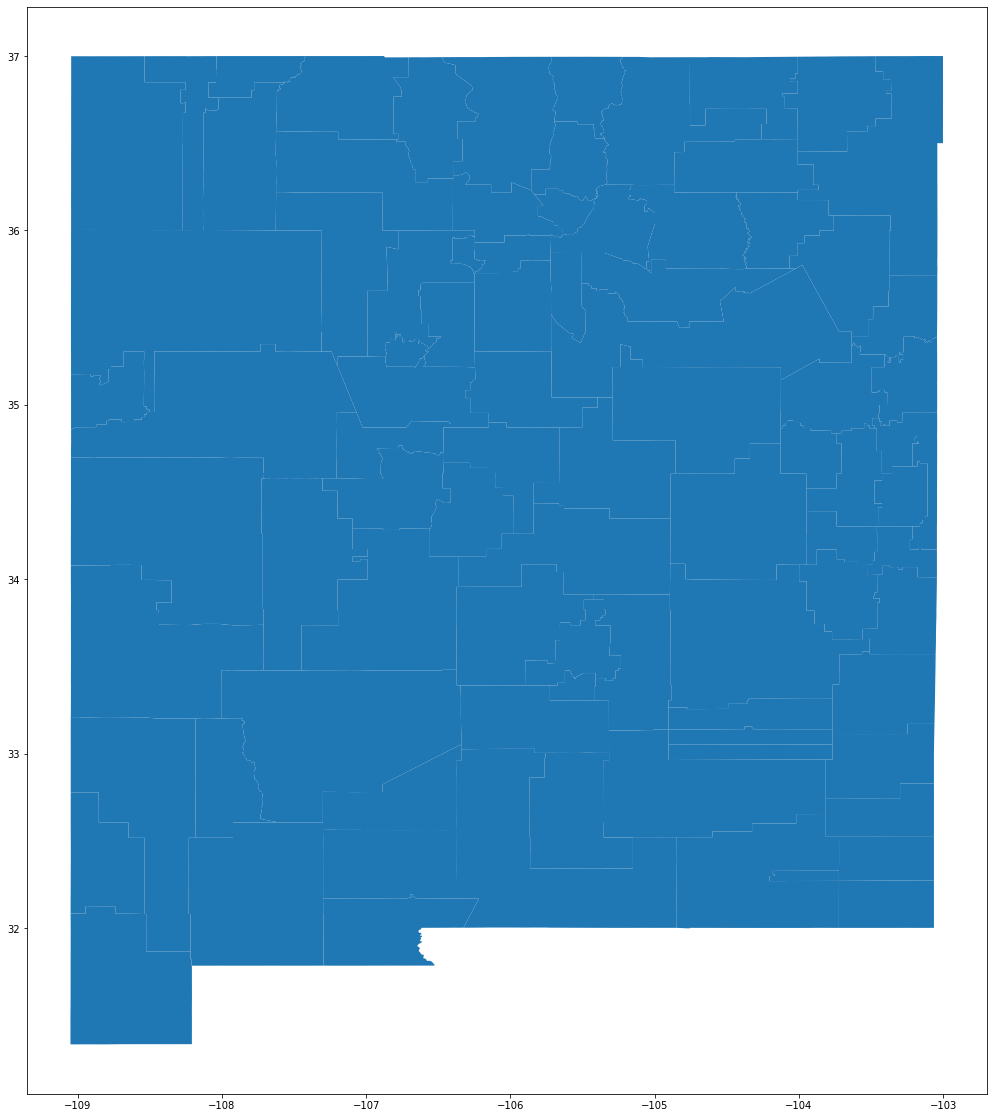

In [7]:
## ----- Plot the Data -----------
import matplotlib.pyplot as plt
%matplotlib inline
geo_df.plot(figsize=(20,20))

Now Let's see what kind of geometry data we have.

In [8]:
geo_df["geometry"].type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

Notice that we have both Polygon and MultiPolygon data. Geopanda's can handle multiple types of geometry in the geometry column, or else we wouldn't have got this far. However, PostGIS cannot. If you would attempt to load your data in a PostGIS table the way it is you would get an error, the error would be determined by if you defined your geometry column as Polygon or MultiPolygon.

Because it is easier to define Polygons as MultiPolygon that is what we are going to do. But think about why this is and what you may have to do to go the other way.

In [9]:
## Changes the Polygon geometries to MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon

geo_df["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in geo_df["geometry"]]

Now lets check the geometry again.

In [10]:
geo_df["geometry"].type.unique()

array(['MultiPolygon'], dtype=object)

### Task: Connect to the PostGIS database
Remember the POSTGIS database is just the PostgreSQL database that has the PostGIS extensions installed. 


In [11]:
## ----- Connect to POSTGIS -----------
import getpass
import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

mypasswd = getpass.getpass()
connection = psycopg2.connect(database = 'dsa_student', 
                              user = 'jbazr6', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
del mypasswd
cursor = connection.cursor()

········


### Task: Define your table, geometry column, and indexing

The table should be named: SSO.new_mexico_school_districts
Note that you should end up with a **coords** column that is a SRID=4326 MultiPolygon of 2-D (Lon,Lat).

In [17]:
## ----- Create Table -----------
sqlCreateTable = """
CREATE TABLE jbazr6.new_mexico_school_districts2 (
  id SERIAL PRIMARY KEY,
  county varchar(100),
  county_nbr int,
  dist_code int,
  name_proper varchar(100),
  shape_area real
);
SELECT AddGeometryColumn('jbazr6','new_mexico_school_districts2','coords',4326,'MultiPolygon',2);
CREATE INDEX idx_new_mexico_school_districts2 ON jbazr6.new_mexico_school_districts2 USING GIST (coords);"""

cursor.execute(sqlCreateTable)

connection.commit()

### Task: Load data into your Table

In [18]:
## ----- Load Data -----------
register_adapter(numpy.int64,AsIs)
register_adapter(numpy.float64,AsIs)

INSERT_SQL = 'INSERT INTO jbazr6.new_mexico_school_districts2 '
INSERT_SQL += ' (county,county_nbr,dist_code,name_proper,shape_area,coords) '
INSERT_SQL += ' values (%s,%s,%s,%s,%s,ST_GeomFromText(%s, 4326))'

with connection, connection.cursor() as cursor:
    for row in geo_df.itertuples():  
        data = (row.COUNTY,row.CNTY_CODE,row.DIST_CODE,row.NAMEPROPER,row.Shape_Area,row.geometry.wkt)      
        cursor.execute(INSERT_SQL,data)


### Check the data exists!

 * Replace SSO with your SSO

### Task Reconnect to POSTGIS

In [14]:
## ----- Reconnect to POSTGIS -----------
mypasswd = getpass.getpass()
connection = psycopg2.connect(database = 'dsa_student', 
                              user = 'jbazr6', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
del mypasswd
cursor = connection.cursor()

········


In [19]:
sqlSelect = """
select count(*) 
 from jbazr6.new_mexico_school_districts2;"""

gdf=pd.read_sql_query(sqlSelect,connection)
gdf.head()

count
0     89

The output should be 89 rows.

In [23]:
sqlSelect = """
select id,county,county_nbr,dist_code
      ,name_proper,shape_area,st_area(coords) 
 from jbazr6.new_mexico_school_districts2 
 limit 10;"""

cursor.execute(sqlSelect)

cursor.fetchall()

InterfaceError: cursor already closed

In [26]:
sqlSelect = """
select id,county,county_nbr,dist_code
      ,name_proper,shape_area,coords 
 from jbazr6.new_mexico_school_districts2 
 limit 10;"""

gdf=gpd.GeoDataFrame.from_postgis(sqlSelect,connection,geom_col='coords' )
gdf.head()

id      county  county_nbr  dist_code     name_proper    shape_area  \
0   1  San Miguel          47         69  Las Vegas City  3.283500e+09   
1   2      Colfax           7          8        Cimarron  3.729510e+09   
2   3       Union          59         84         Clayton  6.828300e+09   
3   4        Taos          55         76            Taos  1.647880e+09   
4   5        Mora          33         44            Mora  1.926290e+09   

                                              coords  
0  MULTIPOLYGON (((-105.50504 35.87068, -105.3542...  
1  MULTIPOLYGON (((-105.12024 36.99540, -105.0657...  
2  MULTIPOLYGON (((-103.00148 36.90955, -103.0017...  
3  MULTIPOLYGON (((-105.61667 36.62500, -105.5869...  
4  MULTIPOLYGON (((-105.17811 36.20281, -105.1751...

### Task: Query the database to answer a couple questions:

#### List the counties with more than 3 school districts, in descending order by number of school districts, then in alphabetic order within a group of the same number of school districts.

In [27]:
## ----- Add SQL Code Below -----------


sqlSelect2 = """
SELECT county, COUNT(*) as school_district_count
FROM jbazr6.new_mexico_school_districts2
GROUP BY county
HAVING COUNT(*) > 3
ORDER BY school_district_count DESC, county ASC;
"""

gdf = pd.read_sql_query(sqlSelect2, connection)
gdf.head()










county  school_district_count
0      Lea                      5
1   Chaves                      4
2   Colfax                      4
3    Curry                      4
4  Lincoln                      4

#### List the top 5 school districts, in descending order by number of populated places.

In [28]:
## ----- Add SQL Code Below -----------

sqlSelect2 = """
SELECT A.dist_code, A.name_proper, COUNT(*) AS num_populated_places
FROM jbazr6.new_mexico_school_districts1 AS A
JOIN jbazr6.new_mexico_populated_places AS B 
ON ST_Contains(A.coords, B.coords)
GROUP BY A.dist_code, A.name_proper
ORDER BY num_populated_places DESC
LIMIT 5;
"""

# Execute the query
gdf = pd.read_sql_query(sqlSelect2, connection)
gdf.head()







dist_code     name_proper  num_populated_places
0          1     Albuquerque                   444
1         43          Gallup                   438
2         68  West Las Vegas                   414
3         55        Espanola                   396
4         88   Grants-Cibola                   330

#### (Optional): List the top 3 counties based on total size of school districts, in descending order by size.  List the size in square kilometers!

In [29]:
## ----- Add SQL Code Below -----------

sqlSelect = """
select county, sum(st_area(coords::geography)/10^6) as sqr_km 
from jbazr6.new_mexico_school_districts1 
group by county 
order by 2 desc 
limit 3;"""

gdf=pd.read_sql_query(sqlSelect,connection)
gdf.head()





county        sqr_km
0    Catron  19532.868436
1     Otero  16983.938691
2  McKinley  14471.130198

Expected Answer:

```SQL
  county  |      sqr_km      
----------+------------------
 Catron   | 19532.8696952213
 Otero    |  16983.887376987
 McKinley |  14471.088162269
(3 rows)
```

---

# File 2: Keyhole Markup Language (KML) format

 * https://web.dsa.missouri.edu/static/data/geodata/gpsrdsddshp.derived.kml
 
This file is a KML formatted file of GPS coordinates of roads in New Mexico.
Read more [here](https://catalog.data.gov/dataset/gps-roads).

KML is a file format used to display geographic data in an Earth browser such as Google Earth. 
KML uses a tag-based structure with nested elements and attributes and is based on the XML standard. 
All tags are case-sensitive and must appear exactly as they are listed in the KML Reference. 

Read about KML [here](https://developers.google.com/kml/documentation/kml_tut)

### Task: Acquire and stage the KML into the `../temp/` folder as you did in the practices.



In [30]:
## ----- Add Acquisition Code Below -----------

# Designate the URL for a file we want;
file_URL = 'https://web.dsa.missouri.edu/static/data/geodata/gpsrdsddshp.derived.kml'

# Designate the local filename
local_file_name = 'SSO.new_mexico_roads.kml'

# Designate the local file name with a path to a temp directory.
     # Your Repo comes with this folder.  If not, use terminal and 
     # navigate to course folder > module2 and them : mkdir temp
file_Path = Path('../temp/')  
file_Path /= local_file_name


# Download the file from `url` and save it locally under `file_Path`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)
    


GEODATA_FILE = Path(file_Path)
GEODATA_FILE = str(GEODATA_FILE.parent.joinpath(GEODATA_FILE.stem + '.kml'))
print(GEODATA_FILE)


../temp/SSO.new_mexico_roads.kml


### Task: Confirm the file name looks correct and then examin the file with Fiona

In [31]:
import fiona

numLayers = len(fiona.listlayers(GEODATA_FILE))
print("'{}' has {} layers".format(GEODATA_FILE, numLayers))

'../temp/SSO.new_mexico_roads.kml' has 1 layers


### Now attempt to load the file into a geopandas data frame (expect an error)

In [32]:
import geopandas as gpd
geo_df = gpd.read_file(GEODATA_FILE, layer=0)
geo_df.tail()

DriverError: unsupported driver: 'KML'

### We get this error because KML is not supported by Fiona. 
So, we have a file that looks like XML that we cannot use a simple library to load it into GeoPandas.
You will need to recall your previous experience in classes and doing data carpentry.
KML is a hierarchical [Document Object Model (DOM)](https://www.w3.org/TR/WD-DOM/introduction.html) similar to [HTML](https://www.w3schools.com/html/), as it is a type of [XML](https://www.w3schools.com/xml/xml_whatis.asp).

## Processing 

Basically, KML is similar in nature to GML.  
So, for the last file you will repeat the exercise above with a changes necessary to import KML instead of GML and into a new table.

The elements we will process are **`Placemark`**s.
These Placemarks have **`LineString`** geometries with a **`coordinates`** list.
```
<Placemark id="17948705"><name>17948705</name>
   <LineString><coordinates>-107.915138244628793,36.809299468994105 -107.915 ... </coordinates></LineString>
   <ExtendedData><SchemaData schemaUrl="#attributes">
     <SimpleData name="NAME">I 40</SimpleData>
     <SimpleData name="TYPE">State Highway</SimpleData>
...
</Placemark>
```
  * There are numerous additional fields, however we will limit our parsing and loading to the Name and Type.

Programmatically, we must do the following:
 1. Parse file into a DOM
 1. Find all `<Placemark>`
 1. Parse each **`Placemark`** into a record with:
    * LineString
    * Name
    * Road Type
 1. Add each record into the database


### Task: Define your table, geometry column, and indexing

Write your SQL Statements below, then copy-and-paste into the terminal database command line.

Note that you should end up with a **coords** column that is a SRID=4326 LINESTRINF of 2-D (Lon,Lat).

In [33]:
## ----- create table ----------

## ----- Reconnect to POSTGIS -----------
import getpass
import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

mypasswd = getpass.getpass()
connection = psycopg2.connect(database = 'dsa_student', 
                              user = 'jbazr6', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
del mypasswd
cursor = connection.cursor()



sqlCreateTable = """
CREATE TABLE jbazr6.new_mexico_roads (
  id SERIAL PRIMARY KEY,
  road_name varchar(100),
  road_type varchar(100),
  road_length real
);
SELECT AddGeometryColumn('jbazr6','new_mexico_roads','coords',4326,'LineString',2);
CREATE INDEX idx_new_mexico_roads ON jbazr6.new_mexico_roads USING GIST (coords);"""
 
cursor.execute(sqlCreateTable)
 
connection.commit()







········


In [62]:
sqlSelect2a = """
SELECT *
FROM  jbazr6.new_mexico_roads;


"""

# Execute the query
gdf = pd.read_sql_query(sqlSelect2a, connection)
gdf.head()

Empty DataFrame
Columns: [id, road_name, road_type, road_length, coords]
Index: []

### Task: Load the table with geospatial data!

 * **NOTE:** You may need to rerun the DB Connection Cell again
 

In [53]:
! pip install beautifulsoup4
# ! pip uninstall -y shapely
! pip install --upgrade pip
! pip install shapely

In [70]:
# ---- Write the code for the insert statement.  
from bs4 import BeautifulSoup
from shapely.geometry import LineString

# Parsing the KML file and inserting data into the table
with open(GEODATA_FILE, encoding='latin1') as file, connection, connection.cursor() as cursor:
    
    print("Parsing file")
    soup = BeautifulSoup(file.read(), 'xml')
    print("DOM created")
    
    INSERT_SQL = 'INSERT INTO jbazr6.new_mexico_roads (road_name, road_type, road_length, coords) '
    INSERT_SQL += 'VALUES (%s, %s,%s, ST_GeomFromText(%s, 4326))'
    
    for ft in soup.find_all('Placemark'):
        linestring = ft.find('LineString')
        coords = linestring.find('coordinates').text.strip()
        
        coords = coords.split(' ')
        coords_tuple = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in coords]
        coords = LineString(coords_tuple)
        
        ed = ft.find('ExtendedData').find_all('SimpleData')
        print(ed)
        name = ed[0].text  # NAME
        road_type = ed[1].text  # TYPE
        road_length = float(ed[3].text)  # LENGTH
        
        data = (name, road_type, road_length, coords.wkt)
        
        cursor.execute(INSERT_SQL, data)
    print("Data Loaded")

# Query the table to verify
sqlSelect2a = "SELECT * FROM jbazr6.new_mexico_roads;"
gdf = pd.read_sql_query(sqlSelect2a, connection)
print(gdf.head())

Parsing file
DOM created
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6089.0</SimpleData>, <SimpleData name="LENGTH">0.129</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6097.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7744.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 575</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">152.0</SimpleData>, <SimpleData name="LENGTH">0.126</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">226.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">283.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDat

[<SimpleData name="NAME">NM 185</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7748.0</SimpleData>, <SimpleData name="LENGTH">0.125</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7655.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9992.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 453</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">307.0</SimpleData>, <SimpleData name="LENGTH">0.162</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">363.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">448.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 1

[<SimpleData name="NAME">SAN FRANCISCO RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2194.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2196.0</SimpleData>, <SimpleData name="ALT_NAME">FL5067</SimpleData>, <SimpleData name="GPSRDSDD_">3002.0</SimpleData>, <SimpleData name="GPSRDSDD_I">3573.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">WYOMING BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2207.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2186.0</SimpleData>, <SimpleData name="ALT_NAME">FL4061</SimpleData>, <SimpleData name="GPSRDSDD_">3013.0</SimpleData>, <SimpleData name="GPSRDSDD_I">3650.0</SimpleData>, <Simple

[<SimpleData name="NAME">NM 18</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7563.0</SimpleData>, <SimpleData name="LENGTH">0.148</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7629.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9829.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FL4004</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1336.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1335.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1830.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">SAN FRANC

[<SimpleData name="NAME">MATTHEW AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3240.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3239.0</SimpleData>, <SimpleData name="ALT_NAME">FL5123</SimpleData>, <SimpleData name="GPSRDSDD_">4224.0</SimpleData>, <SimpleData name="GPSRDSDD_I">10660.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CANDELARIA BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3293.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3294.0</SimpleData>, <SimpleData name="ALT_NAME">FL4048</SimpleData>, <SimpleData name="GPSRDSDD_">4281.0</SimpleData>, <SimpleData name="GPSRDSDD_I">11021.0</SimpleData>, <SimpleDa

[<SimpleData name="NAME">COORS RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3530.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3549.0</SimpleData>, <SimpleData name="ALT_NAME">FL4001</SimpleData>, <SimpleData name="GPSRDSDD_">4586.0</SimpleData>, <SimpleData name="GPSRDSDD_I">103.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">ORTEGA RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1923.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1920.0</SimpleData>, <SimpleData name="ALT_NAME">FL5124</SimpleData>, <SimpleData name="GPSRDSDD_">2641.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1576.0</SimpleData>, <SimpleData name="obs

[<SimpleData name="NAME">FR4140</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6102.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6100.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7752.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">167.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">170.0</SimpleData>, <SimpleData name="ALT_NAME">US 64</SimpleData>, <SimpleData name="GPSRDSDD_">203.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">583.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">579.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">736.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">837.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">841.0</SimpleData>, <SimpleData name="ALT_NAME">US 285</SimpleData>, <SimpleData name="GPSRDSDD_">1075.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleD

[<SimpleData name="NAME">CAMINO ALIRE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">867.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">856.0</SimpleData>, <SimpleData name="ALT_NAME">FL4804</SimpleData>, <SimpleData name="GPSRDSDD_">1116.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">MALONEY AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1104.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1101.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1482.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<Sim

[<SimpleData name="NAME">MATTHEW AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3231.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3232.0</SimpleData>, <SimpleData name="ALT_NAME">FL5123</SimpleData>, <SimpleData name="GPSRDSDD_">4216.0</SimpleData>, <SimpleData name="GPSRDSDD_I">10607.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1248.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1253.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1705.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">

[<SimpleData name="NAME">NM 9</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8584.0</SimpleData>, <SimpleData name="LENGTH">0.167</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8592.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11250.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 3</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1665.0</SimpleData>, <SimpleData name="LENGTH">0.138</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1747.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2417.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">MOON S

[<SimpleData name="NAME">JEFFERSON ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2613.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2616.0</SimpleData>, <SimpleData name="ALT_NAME">FL5037</SimpleData>, <SimpleData name="GPSRDSDD_">3508.0</SimpleData>, <SimpleData name="GPSRDSDD_I">6935.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4137</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2608.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2620.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3513.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleD

[<SimpleData name="NAME">INDIAN SCHOOL RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3961.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3962.0</SimpleData>, <SimpleData name="ALT_NAME">FL5035</SimpleData>, <SimpleData name="GPSRDSDD_">5105.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14341.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">MORRIS ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3963.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3826.0</SimpleData>, <SimpleData name="ALT_NAME">FL5051</SimpleData>, <SimpleData name="GPSRDSDD_">5106.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14347.0</SimpleData>, <SimpleD

[<SimpleData name="NAME">GIBSON BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5626.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5627.0</SimpleData>, <SimpleData name="ALT_NAME">FL4078</SimpleData>, <SimpleData name="GPSRDSDD_">7104.0</SimpleData>, <SimpleData name="GPSRDSDD_I">24028.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GIBSON BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5628.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5630.0</SimpleData>, <SimpleData name="ALT_NAME">FL4078</SimpleData>, <SimpleData name="GPSRDSDD_">7107.0</SimpleData>, <SimpleData name="GPSRDSDD_I">24043.0</SimpleData>, <SimpleData

[<SimpleData name="NAME">NM 156</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6271.0</SimpleData>, <SimpleData name="LENGTH">0.085</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6256.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8003.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6273.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6265.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8004.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <Simp

[<SimpleData name="NAME">BL00012</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6781.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6780.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8705.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CALIFORNIA STREET</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6777.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6774.0</SimpleData>, <SimpleData name="ALT_NAME">US 60; BL00012</SimpleData>, <SimpleData name="GPSRDSDD_">8702.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>

[<SimpleData name="NAME">US 380</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7097.0</SimpleData>, <SimpleData name="LENGTH">0.069</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7098.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9113.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 181</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7092.0</SimpleData>, <SimpleData name="LENGTH">0.029</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7104.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9123.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR2017

[<SimpleData name="NAME">ESPINA ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8058.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8043.0</SimpleData>, <SimpleData name="ALT_NAME">FL5519</SimpleData>, <SimpleData name="GPSRDSDD_">10446.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7548.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7546.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9720.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">N

[<SimpleData name="NAME">US 70</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7859.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7856.0</SimpleData>, <SimpleData name="ALT_NAME">US 82</SimpleData>, <SimpleData name="GPSRDSDD_">10153.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7893.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7902.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10209.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">EVELYN 

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8420.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8413.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11002.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8420.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8416.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11003.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</Simple

[<SimpleData name="NAME">NM 338</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8639.0</SimpleData>, <SimpleData name="LENGTH">0.013</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8638.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11297.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6793.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6788.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8723.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 246<

[<SimpleData name="NAME">FR2108</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">955.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">945.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1249.0</SimpleData>, <SimpleData name="GPSRDSDD_I">302.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">BL00014</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">965.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">968.0</SimpleData>, <SimpleData name="ALT_NAME">NM 466</SimpleData>, <SimpleData name="GPSRDSDD_">1269.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData na

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7848.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7850.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10137.0</SimpleData>, <SimpleData name="GPSRDSDD_I">300.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">MAYFIELD LN</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7873.0</SimpleData>, <SimpleData name="LENGTH">0.006</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7866.0</SimpleData>, <SimpleData name="ALT_NAME">FL5570</SimpleData>, <SimpleData name="GPSRDSDD_">10169.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleD

[<SimpleData name="NAME">LOUISIANA BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3908.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3832.0</SimpleData>, <SimpleData name="ALT_NAME">FL4057</SimpleData>, <SimpleData name="GPSRDSDD_">5042.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14258.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">804.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">807.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1029.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<Simple

[<SimpleData name="NAME">NM 522</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">30.0</SimpleData>, <SimpleData name="LENGTH">0.024</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">13.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">21.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 170</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">31.0</SimpleData>, <SimpleData name="LENGTH">0.072</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">22.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 196</SimpleDa

[<SimpleData name="NAME">NM 17</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">72.0</SimpleData>, <SimpleData name="LENGTH">0.026</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">52.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">75.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 64</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">73.0</SimpleData>, <SimpleData name="LENGTH">0.079</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">36.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">76.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">5TH ST</SimpleData>,

[<SimpleData name="NAME">NM 527</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">133.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">133.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">156.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 527</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">134.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">133.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">157.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">RIO GRAND

[<SimpleData name="NAME">30TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">178.0</SimpleData>, <SimpleData name="LENGTH">0.041</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">184.0</SimpleData>, <SimpleData name="ALT_NAME">FL4392</SimpleData>, <SimpleData name="GPSRDSDD_">220.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">30TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">185.0</SimpleData>, <SimpleData name="LENGTH">0.012</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">183.0</SimpleData>, <SimpleData name="ALT_NAME">FL4392</SimpleData>, <SimpleData name="GPSRDSDD_">221.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<

[<SimpleData name="NAME">US 64</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">207.0</SimpleData>, <SimpleData name="LENGTH">0.077</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">223.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">284.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 64</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">176.0</SimpleData>, <SimpleData name="LENGTH">0.223</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">227.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">285.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 512</SimpleDat

[<SimpleData name="NAME">NM 378</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">236.0</SimpleData>, <SimpleData name="LENGTH">0.168</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">268.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">335.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">263.0</SimpleData>, <SimpleData name="LENGTH">0.008</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">269.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">337.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 378</Simpl

[<SimpleData name="NAME">US 64</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">298.0</SimpleData>, <SimpleData name="LENGTH">0.09</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">307.0</SimpleData>, <SimpleData name="ALT_NAME">US 87</SimpleData>, <SimpleData name="GPSRDSDD_">383.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 112</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">306.0</SimpleData>, <SimpleData name="LENGTH">0.172</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">267.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">384.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAM

[<SimpleData name="NAME">NM 204</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">348.0</SimpleData>, <SimpleData name="LENGTH">0.06</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">316.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">432.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 64</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">307.0</SimpleData>, <SimpleData name="LENGTH">0.181</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">349.0</SimpleData>, <SimpleData name="ALT_NAME">US 87</SimpleData>, <SimpleData name="GPSRDSDD_">433.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAM

[<SimpleData name="NAME">NM 538</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">365.0</SimpleData>, <SimpleData name="LENGTH">0.022</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">384.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">478.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 87</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">384.0</SimpleData>, <SimpleData name="LENGTH">0.02</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">368.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">479.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData

[<SimpleData name="NAME">NM 567</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">428.0</SimpleData>, <SimpleData name="LENGTH">0.094</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">430.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">540.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">424.0</SimpleData>, <SimpleData name="LENGTH">0.009</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">433.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">541.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 21</SimpleD

[<SimpleData name="NAME">US 56</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">469.0</SimpleData>, <SimpleData name="LENGTH">0.214</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">470.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">593.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 56</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">470.0</SimpleData>, <SimpleData name="LENGTH">0.11</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">471.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">594.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 56</SimpleData>

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">498.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">500.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">634.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">501.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">497.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">635.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Intersta

[<SimpleData name="NAME">NM 75</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">541.0</SimpleData>, <SimpleData name="LENGTH">0.091</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">538.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">683.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 75</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">533.0</SimpleData>, <SimpleData name="LENGTH">0.025</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">541.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">684.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 562</Sim

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">572.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">577.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">724.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">578.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">573.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">726.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name

[<SimpleData name="NAME">NM 120</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">622.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">621.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">791.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 120</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">622.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">623.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">792.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 102</S

[<SimpleData name="NAME">NM 39</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">563.0</SimpleData>, <SimpleData name="LENGTH">0.196</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">685.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">873.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 120</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">685.0</SimpleData>, <SimpleData name="LENGTH">0.02</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">680.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">874.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 442</Sim

[<SimpleData name="NAME">SANDIA CANYON</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">722.0</SimpleData>, <SimpleData name="LENGTH">0.025</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">720.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">922.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 666</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">723.0</SimpleData>, <SimpleData name="LENGTH">0.204</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">654.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">923.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 161

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">762.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">760.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">968.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">757.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">761.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">967.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 197</SimpleData>, <SimpleData name="TYPE">State 

[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">802.0</SimpleData>, <SimpleData name="LENGTH">0.022</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">816.0</SimpleData>, <SimpleData name="ALT_NAME">US 285</SimpleData>, <SimpleData name="GPSRDSDD_">1041.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 590</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">792.0</SimpleData>, <SimpleData name="LENGTH">0.064</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">819.0</SimpleData>, <SimpleData name="ALT_NAME">BISHOPS LODGE ROAD</SimpleData>, <SimpleData name="GPSRDSDD_">1044.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData nam

[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">874.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">886.0</SimpleData>, <SimpleData name="ALT_NAME">US 285</SimpleData>, <SimpleData name="GPSRDSDD_">1144.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CORDOVA RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">886.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">880.0</SimpleData>, <SimpleData name="ALT_NAME">FL4728</SimpleData>, <SimpleData name="GPSRDSDD_">1145.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed

[<SimpleData name="NAME">RODEO RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">951.0</SimpleData>, <SimpleData name="LENGTH">0.017</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">958.0</SimpleData>, <SimpleData name="ALT_NAME">FL4727</SimpleData>, <SimpleData name="GPSRDSDD_">1255.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">959.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">957.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1256.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <Simpl

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1029.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1024.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1362.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1028.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1030.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1363.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</Simple

[<SimpleData name="NAME">2ND ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1103.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1101.0</SimpleData>, <SimpleData name="ALT_NAME">FL4425</SimpleData>, <SimpleData name="GPSRDSDD_">1481.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">1103.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1107.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1486.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="N

[<SimpleData name="NAME">AZTEC AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1186.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1187.0</SimpleData>, <SimpleData name="ALT_NAME">FL4430</SimpleData>, <SimpleData name="GPSRDSDD_">1612.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 118</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1163.0</SimpleData>, <SimpleData name="LENGTH">0.024</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1188.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1613.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDa

[<SimpleData name="NAME">NM 602</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1186.0</SimpleData>, <SimpleData name="LENGTH">0.024</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1242.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1689.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR2108</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1243.0</SimpleData>, <SimpleData name="LENGTH">0.031</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1158.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1690.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40

[<SimpleData name="NAME">US 54</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">1304.0</SimpleData>, <SimpleData name="LENGTH">0.132</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1011.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1785.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1302.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1303.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1786.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">L

[<SimpleData name="NAME">NM 118</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1372.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1370.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1887.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 281</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1217.0</SimpleData>, <SimpleData name="LENGTH">0.131</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1217.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1888.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 11

[<SimpleData name="NAME">NM 553</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1418.0</SimpleData>, <SimpleData name="LENGTH">0.026</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1438.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1977.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 285</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">1438.0</SimpleData>, <SimpleData name="LENGTH">0.088</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1279.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">1978.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">SF

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">1448.0</SimpleData>, <SimpleData name="LENGTH">0.043</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1495.0</SimpleData>, <SimpleData name="ALT_NAME">US 84</SimpleData>, <SimpleData name="GPSRDSDD_">2058.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR2116</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1496.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1495.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2059.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NA

[<SimpleData name="NAME">FR2122</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1556.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1555.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2147.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">1530.0</SimpleData>, <SimpleData name="LENGTH">0.057</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1556.0</SimpleData>, <SimpleData name="ALT_NAME">US 84</SimpleData>, <SimpleData name="GPSRDSDD_">2148.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NA

[<SimpleData name="NAME">FR2130</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1630.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1634.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2264.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR2116</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1616.0</SimpleData>, <SimpleData name="LENGTH">0.068</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1602.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2265.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</Sim

[<SimpleData name="NAME">NM 313</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1635.0</SimpleData>, <SimpleData name="LENGTH">0.101</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1685.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2328.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 550</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">1685.0</SimpleData>, <SimpleData name="LENGTH">0.029</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1679.0</SimpleData>, <SimpleData name="ALT_NAME">old NM 44</SimpleData>, <SimpleData name="GPSRDSDD_">2329.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDa

[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">1733.0</SimpleData>, <SimpleData name="LENGTH">0.021</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1744.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2412.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4020</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1744.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1743.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2413.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 528</Sim

[<SimpleData name="NAME">MEADOWLARK LA</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1800.0</SimpleData>, <SimpleData name="LENGTH">0.007</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1796.0</SimpleData>, <SimpleData name="ALT_NAME">FL5114</SimpleData>, <SimpleData name="GPSRDSDD_">2487.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 528</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">1801.0</SimpleData>, <SimpleData name="LENGTH">0.01</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1790.0</SimpleData>, <SimpleData name="ALT_NAME">RIO RANCHO DR</SimpleData>, <SimpleData name="GPSRDSDD_">2488.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData n

[<SimpleData name="NAME">FR2524</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1884.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1874.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2592.0</SimpleData>, <SimpleData name="GPSRDSDD_I">28.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">1872.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1885.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2593.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <Simple

[<SimpleData name="NAME">PASEO DEL NORTE BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1958.0</SimpleData>, <SimpleData name="LENGTH">0.013</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1969.0</SimpleData>, <SimpleData name="ALT_NAME">NM 423</SimpleData>, <SimpleData name="GPSRDSDD_">2701.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">BARSTOW ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">1971.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">1957.0</SimpleData>, <SimpleData name="ALT_NAME">FL5005</SimpleData>, <SimpleData name="GPSRDSDD_">2704.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1879.0</SimpleData>, <SimpleD

[<SimpleData name="NAME">LOUISIANA BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2058.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2035.0</SimpleData>, <SimpleData name="ALT_NAME">FL4057</SimpleData>, <SimpleData name="GPSRDSDD_">2825.0</SimpleData>, <SimpleData name="GPSRDSDD_I">2577.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">PASEO DEL NORTE BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2053.0</SimpleData>, <SimpleData name="LENGTH">0.009</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2058.0</SimpleData>, <SimpleData name="ALT_NAME">NM 423</SimpleData>, <SimpleData name="GPSRDSDD_">2826.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <Sim

[<SimpleData name="NAME">FR4117</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2137.0</SimpleData>, <SimpleData name="LENGTH">0.014</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2149.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2940.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">2150.0</SimpleData>, <SimpleData name="LENGTH">0.036</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2138.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">2941.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NIMITZ DR</

[<SimpleData name="NAME">FR2537</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2271.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2272.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3087.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GOLF COURSE RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2015.0</SimpleData>, <SimpleData name="LENGTH">0.019</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2276.0</SimpleData>, <SimpleData name="ALT_NAME">FL4079</SimpleData>, <SimpleData name="GPSRDSDD_">3091.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDa

[<SimpleData name="NAME">GOLDEN ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2401.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2363.0</SimpleData>, <SimpleData name="ALT_NAME">FL5027</SimpleData>, <SimpleData name="GPSRDSDD_">3239.0</SimpleData>, <SimpleData name="GPSRDSDD_I">5706.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">ACADEMY RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2359.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2402.0</SimpleData>, <SimpleData name="ALT_NAME">FL4064</SimpleData>, <SimpleData name="GPSRDSDD_">3240.0</SimpleData>, <SimpleData name="GPSRDSDD_I">5424.0</SimpleData>, <SimpleData name

[<SimpleData name="NAME">BL00032</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2493.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2509.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3374.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">2509.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2459.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3375.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">L;AYTON AV

[<SimpleData name="NAME">SAN MATEO BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2609.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2590.0</SimpleData>, <SimpleData name="ALT_NAME">FL5096</SimpleData>, <SimpleData name="GPSRDSDD_">3499.0</SimpleData>, <SimpleData name="GPSRDSDD_I">6889.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">2560.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2610.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3500.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<Simpl

[<SimpleData name="NAME">EUBANK BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2731.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2707.0</SimpleData>, <SimpleData name="ALT_NAME">FL4063</SimpleData>, <SimpleData name="GPSRDSDD_">3641.0</SimpleData>, <SimpleData name="GPSRDSDD_I">7365.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">EDITH BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2732.0</SimpleData>, <SimpleData name="LENGTH">0.016</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2410.0</SimpleData>, <SimpleData name="ALT_NAME">FL5098</SimpleData>, <SimpleData name="GPSRDSDD_">3642.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name=

[<SimpleData name="NAME">ALEXANDER BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2847.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2821.0</SimpleData>, <SimpleData name="ALT_NAME">FL5111</SimpleData>, <SimpleData name="GPSRDSDD_">3778.0</SimpleData>, <SimpleData name="GPSRDSDD_I">8101.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">JOHN SALAZAR</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2797.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2847.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3779.0</SimpleData>, <SimpleData name="GPSRDSDD_I">8102.0</SimpleData>, <SimpleData name="observed"

[<SimpleData name="NAME">SAN PEDRO DR</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2996.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2980.0</SimpleData>, <SimpleData name="ALT_NAME">FL4053</SimpleData>, <SimpleData name="GPSRDSDD_">3950.0</SimpleData>, <SimpleData name="GPSRDSDD_I">9045.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CAMINO DE LA SIERRA</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">2997.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">2987.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">3951.0</SimpleData>, <SimpleData name="GPSRDSDD_I">8863.0</SimpleData>, <SimpleData name="obse

[<SimpleData name="NAME">COMANCHE RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3138.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3137.0</SimpleData>, <SimpleData name="ALT_NAME">FL5016</SimpleData>, <SimpleData name="GPSRDSDD_">4108.0</SimpleData>, <SimpleData name="GPSRDSDD_I">9758.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">COMANCHE RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3132.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3138.0</SimpleData>, <SimpleData name="ALT_NAME">FL5016</SimpleData>, <SimpleData name="GPSRDSDD_">4109.0</SimpleData>, <SimpleData name="GPSRDSDD_I">9759.0</SimpleData>, <SimpleData n

[<SimpleData name="NAME">CANDELARIA BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3370.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3366.0</SimpleData>, <SimpleData name="ALT_NAME">FL4048</SimpleData>, <SimpleData name="GPSRDSDD_">4362.0</SimpleData>, <SimpleData name="GPSRDSDD_I">11172.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CANDELARIA BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3366.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3371.0</SimpleData>, <SimpleData name="ALT_NAME">FL4048</SimpleData>, <SimpleData name="GPSRDSDD_">4365.0</SimpleData>, <SimpleData name="GPSRDSDD_I">11158.0</SimpleData>, <Si

[<SimpleData name="NAME">FR4118</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3347.0</SimpleData>, <SimpleData name="LENGTH">0.026</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3498.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4526.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4133</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3442.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3498.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4527.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">COORS RD<

[<SimpleData name="NAME">6TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3667.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3660.0</SimpleData>, <SimpleData name="ALT_NAME">FL4027</SimpleData>, <SimpleData name="GPSRDSDD_">4716.0</SimpleData>, <SimpleData name="GPSRDSDD_I">13043.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3667.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3648.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4717.0</SimpleData>, <SimpleData name="GPSRDSDD_I">27.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">MENAUL

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3726.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3745.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4837.0</SimpleData>, <SimpleData name="GPSRDSDD_I">100.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">3747.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3714.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4838.0</SimpleData>, <SimpleData name="GPSRDSDD_I">26.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">RIO GRANDE BLVD</SimpleDat

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3839.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3740.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4966.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">3839.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3757.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">4967.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">12TH ST</SimpleData>, <Simple

[<SimpleData name="NAME">INDIAN SCHOOL RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3953.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3954.0</SimpleData>, <SimpleData name="ALT_NAME">FL5035</SimpleData>, <SimpleData name="GPSRDSDD_">5097.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14324.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">INDIAN SCHOOL RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">3954.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">3955.0</SimpleData>, <SimpleData name="ALT_NAME">FL5035</SimpleData>, <SimpleData name="GPSRDSDD_">5098.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14329.0</SimpleData>, <Simp

[<SimpleData name="NAME">INDIAN SCHOOL RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4053.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4071.0</SimpleData>, <SimpleData name="ALT_NAME">FL5035</SimpleData>, <SimpleData name="GPSRDSDD_">5226.0</SimpleData>, <SimpleData name="GPSRDSDD_I">14933.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">12TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4072.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4042.0</SimpleData>, <SimpleData name="ALT_NAME">FL4023</SimpleData>, <SimpleData name="GPSRDSDD_">5227.0</SimpleData>, <SimpleData name="GPSRDSDD_I">15327.0</SimpleData>, <SimpleDat

[<SimpleData name="NAME">CONSTITUTION AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4180.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4183.0</SimpleData>, <SimpleData name="ALT_NAME">FL5017</SimpleData>, <SimpleData name="GPSRDSDD_">5356.0</SimpleData>, <SimpleData name="GPSRDSDD_I">15819.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CONSTITUTION AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4184.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4176.0</SimpleData>, <SimpleData name="ALT_NAME">FL5017</SimpleData>, <SimpleData name="GPSRDSDD_">5357.0</SimpleData>, <SimpleData name="GPSRDSDD_I">15820.0</SimpleData>, <

[<SimpleData name="NAME">CONSTITUTION AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4298.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4297.0</SimpleData>, <SimpleData name="ALT_NAME">FL5017</SimpleData>, <SimpleData name="GPSRDSDD_">5483.0</SimpleData>, <SimpleData name="GPSRDSDD_I">16040.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CONSTITUTION AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4295.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4298.0</SimpleData>, <SimpleData name="ALT_NAME">FL5017</SimpleData>, <SimpleData name="GPSRDSDD_">5484.0</SimpleData>, <SimpleData name="GPSRDSDD_I">16041.0</SimpleData>, <

[<SimpleData name="NAME">LOMAS BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4406.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4409.0</SimpleData>, <SimpleData name="ALT_NAME">FL4040</SimpleData>, <SimpleData name="GPSRDSDD_">5624.0</SimpleData>, <SimpleData name="GPSRDSDD_I">16909.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">LOMAS BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4410.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4407.0</SimpleData>, <SimpleData name="ALT_NAME">FL4040</SimpleData>, <SimpleData name="GPSRDSDD_">5625.0</SimpleData>, <SimpleData name="GPSRDSDD_I">16885.0</SimpleData>, <SimpleData nam

[<SimpleData name="NAME">EUBANK BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4515.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4448.0</SimpleData>, <SimpleData name="ALT_NAME">FL4063</SimpleData>, <SimpleData name="GPSRDSDD_">5753.0</SimpleData>, <SimpleData name="GPSRDSDD_I">17333.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GRAND AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4516.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4502.0</SimpleData>, <SimpleData name="ALT_NAME">FL4036</SimpleData>, <SimpleData name="GPSRDSDD_">5754.0</SimpleData>, <SimpleData name="GPSRDSDD_I">17611.0</SimpleData>, <SimpleData n

[<SimpleData name="NAME">PENNSYLVANIA ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4626.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4522.0</SimpleData>, <SimpleData name="ALT_NAME">FL5061</SimpleData>, <SimpleData name="GPSRDSDD_">5882.0</SimpleData>, <SimpleData name="GPSRDSDD_I">17804.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">LOMAS BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4623.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4626.0</SimpleData>, <SimpleData name="ALT_NAME">FL4040</SimpleData>, <SimpleData name="GPSRDSDD_">5883.0</SimpleData>, <SimpleData name="GPSRDSDD_I">17805.0</SimpleData>, <SimpleDat

[<SimpleData name="NAME">FR4109</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4376.0</SimpleData>, <SimpleData name="LENGTH">0.022</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4739.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">6021.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4102</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4660.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4739.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">6022.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">LOMAS BLV

[<SimpleData name="NAME">LEAD AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4842.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4832.0</SimpleData>, <SimpleData name="ALT_NAME">FL4030</SimpleData>, <SimpleData name="GPSRDSDD_">6155.0</SimpleData>, <SimpleData name="GPSRDSDD_I">18966.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">EUBANK BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4843.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4834.0</SimpleData>, <SimpleData name="ALT_NAME">FL4063</SimpleData>, <SimpleData name="GPSRDSDD_">6156.0</SimpleData>, <SimpleData name="GPSRDSDD_I">18733.0</SimpleData>, <SimpleData name

[<SimpleData name="NAME">LEAD AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4932.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4937.0</SimpleData>, <SimpleData name="ALT_NAME">FL4030</SimpleData>, <SimpleData name="GPSRDSDD_">6286.0</SimpleData>, <SimpleData name="GPSRDSDD_I">19654.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 333</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">4938.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">4851.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">6287.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<Simpl

[<SimpleData name="NAME">COPPER AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5050.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5051.0</SimpleData>, <SimpleData name="ALT_NAME">FL5019</SimpleData>, <SimpleData name="GPSRDSDD_">6417.0</SimpleData>, <SimpleData name="GPSRDSDD_I">19793.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">TINGLEY DR</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">4908.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5052.0</SimpleData>, <SimpleData name="ALT_NAME">FL5078</SimpleData>, <SimpleData name="GPSRDSDD_">6418.0</SimpleData>, <SimpleData name="GPSRDSDD_I">20162.0</SimpleData>, <SimpleData n

[<SimpleData name="NAME">COAL AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5155.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5157.0</SimpleData>, <SimpleData name="ALT_NAME">FL4028</SimpleData>, <SimpleData name="GPSRDSDD_">6543.0</SimpleData>, <SimpleData name="GPSRDSDD_I">20637.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">COAL AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5157.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5158.0</SimpleData>, <SimpleData name="ALT_NAME">FL4028</SimpleData>, <SimpleData name="GPSRDSDD_">6544.0</SimpleData>, <SimpleData name="GPSRDSDD_I">20642.0</SimpleData>, <SimpleData name=

[<SimpleData name="NAME">ZUNI RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5265.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5270.0</SimpleData>, <SimpleData name="ALT_NAME">FL4030</SimpleData>, <SimpleData name="GPSRDSDD_">6669.0</SimpleData>, <SimpleData name="GPSRDSDD_I">21293.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">ZUNI RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5269.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5271.0</SimpleData>, <SimpleData name="ALT_NAME">FL4030</SimpleData>, <SimpleData name="GPSRDSDD_">6670.0</SimpleData>, <SimpleData name="GPSRDSDD_I">21284.0</SimpleData>, <SimpleData name="o

[<SimpleData name="NAME">AVENIDA CESAR CHAVEZ</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5379.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5378.0</SimpleData>, <SimpleData name="ALT_NAME">FL4014</SimpleData>, <SimpleData name="GPSRDSDD_">6800.0</SimpleData>, <SimpleData name="GPSRDSDD_I">22244.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">BRIDGE BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5380.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5368.0</SimpleData>, <SimpleData name="ALT_NAME">FL4014</SimpleData>, <SimpleData name="GPSRDSDD_">6801.0</SimpleData>, <SimpleData name="GPSRDSDD_I">22355.0</SimpleData>, <S

[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">5430.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5491.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">6938.0</SimpleData>, <SimpleData name="GPSRDSDD_I">26.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5437.0</SimpleData>, <SimpleData name="LENGTH">0.007</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5491.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">6939.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">EUBANK BLVD</SimpleData>, <S

[<SimpleData name="NAME">GIBSON BLVD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5591.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5594.0</SimpleData>, <SimpleData name="ALT_NAME">FL4078</SimpleData>, <SimpleData name="GPSRDSDD_">7055.0</SimpleData>, <SimpleData name="GPSRDSDD_I">23893.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5595.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5520.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7056.0</SimpleData>, <SimpleData name="GPSRDSDD_I">28.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"

[<SimpleData name="NAME">NM 129</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">5681.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5678.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7170.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4105</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5682.0</SimpleData>, <SimpleData name="LENGTH">0.011</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5609.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7171.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GOFF BLV

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5778.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5776.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7294.0</SimpleData>, <SimpleData name="GPSRDSDD_I">100.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4050</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5462.0</SimpleData>, <SimpleData name="LENGTH">0.147</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5779.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7295.0</SimpleData>, <SimpleData name="GPSRDSDD_I">100.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4035</SimpleData>, <S

[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">5840.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5852.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7391.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4051</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5853.0</SimpleData>, <SimpleData name="LENGTH">0.057</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5816.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7392.0</SimpleData>, <SimpleData name="GPSRDSDD_I">100.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4040</S

[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">5930.0</SimpleData>, <SimpleData name="LENGTH">0.007</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5924.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7495.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 285</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">5915.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5931.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7496.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</Simpl

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5981.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5992.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7589.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">5992.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">5986.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7590.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4072</SimpleData>, <SimpleData name="TYPE">

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6056.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6057.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7689.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6057.0</SimpleData>, <SimpleData name="LENGTH">0.074</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6048.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7690.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleDat

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6133.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6129.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7792.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 40</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6133.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6131.0</SimpleData>, <SimpleData name="ALT_NAME">US 84</SimpleData>, <SimpleData name="GPSRDSDD_">7793.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR4088</Simp

[<SimpleData name="NAME">FR4095</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6211.0</SimpleData>, <SimpleData name="LENGTH">0.016</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6199.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7906.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6213.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6212.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7908.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <Simple

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6265.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6261.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7990.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 317</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6266.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6265.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">7991.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <Simp

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6311.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6309.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8053.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6311.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6308.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8054.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">DON PASCUAL</SimpleData>, <Si

[<SimpleData name="NAME">LA ENTRADA</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6332.0</SimpleData>, <SimpleData name="LENGTH">0.059</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6342.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8096.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6337.0</SimpleData>, <SimpleData name="LENGTH">0.022</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6342.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8097.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">LA ENTRADA</SimpleData>

[<SimpleData name="NAME">MANZANO EXPR</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6399.0</SimpleData>, <SimpleData name="LENGTH">0.104</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6345.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8179.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6400.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6394.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8180.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <S

[<SimpleData name="NAME">NM 55</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6418.0</SimpleData>, <SimpleData name="LENGTH">0.076</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6448.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8245.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 84</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6449.0</SimpleData>, <SimpleData name="LENGTH">0.136</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6371.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8246.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 60</S

[<SimpleData name="NAME">US 60</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6478.0</SimpleData>, <SimpleData name="LENGTH">0.044</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6490.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8300.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 60</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6476.0</SimpleData>, <SimpleData name="LENGTH">0.121</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6491.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8301.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 601</Sim

[<SimpleData name="NAME">NM 212</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6526.0</SimpleData>, <SimpleData name="LENGTH">0.024</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6509.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8342.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 272</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6507.0</SimpleData>, <SimpleData name="LENGTH">0.047</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6526.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8343.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 

[<SimpleData name="NAME">NM 270</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6577.0</SimpleData>, <SimpleData name="LENGTH">0.024</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6584.0</SimpleData>, <SimpleData name="ALT_NAME">BRADY AVE; NORRIS STREET</SimpleData>, <SimpleData name="GPSRDSDD_">8437.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 70</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6572.0</SimpleData>, <SimpleData name="LENGTH">0.008</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6584.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8438.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6624.0</SimpleData>, <SimpleData name="LENGTH">0.095</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6604.0</SimpleData>, <SimpleData name="ALT_NAME">US 60</SimpleData>, <SimpleData name="GPSRDSDD_">8485.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6625.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6627.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8487.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</Simple

[<SimpleData name="NAME">S AVENUE I</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6685.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6686.0</SimpleData>, <SimpleData name="ALT_NAME">FL4640</SimpleData>, <SimpleData name="GPSRDSDD_">8572.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GLOBE/ELBE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6678.0</SimpleData>, <SimpleData name="LENGTH">0.007</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6687.0</SimpleData>, <SimpleData name="ALT_NAME">FL4643</SimpleData>, <SimpleData name="GPSRDSDD_">8573.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="obs

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6751.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6748.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8661.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 52</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6752.0</SimpleData>, <SimpleData name="LENGTH">0.037</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6732.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8662.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 166</S

[<SimpleData name="NAME">NM 12</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6808.0</SimpleData>, <SimpleData name="LENGTH">0.216</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6753.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8741.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 54</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">6809.0</SimpleData>, <SimpleData name="LENGTH">0.197</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6728.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8742.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 12</S

[<SimpleData name="NAME">NM 168</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6811.0</SimpleData>, <SimpleData name="LENGTH">0.14</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6842.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8785.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 114</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6834.0</SimpleData>, <SimpleData name="LENGTH">0.029</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6844.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8787.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 2

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6870.0</SimpleData>, <SimpleData name="LENGTH">0.006</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6864.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8816.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6863.0</SimpleData>, <SimpleData name="LENGTH">0.008</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6871.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8817.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleDat

[<SimpleData name="NAME">NM 1</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6913.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6912.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8875.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">6907.0</SimpleData>, <SimpleData name="LENGTH">0.018</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6913.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8876.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 159</Si

[<SimpleData name="NAME">NM 59</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6947.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6948.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8914.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 59</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6950.0</SimpleData>, <SimpleData name="LENGTH">0.032</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6946.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8915.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25<

[<SimpleData name="NAME">COUNTRY CLUB</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">6996.0</SimpleData>, <SimpleData name="LENGTH">0.017</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6997.0</SimpleData>, <SimpleData name="ALT_NAME">FL4712</SimpleData>, <SimpleData name="GPSRDSDD_">8973.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 159</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">6994.0</SimpleData>, <SimpleData name="LENGTH">0.154</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6985.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">8974.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<Simpl

[<SimpleData name="NAME">NM 52</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7007.0</SimpleData>, <SimpleData name="LENGTH">0.186</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">6963.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9021.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">UNION AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7036.0</SimpleData>, <SimpleData name="LENGTH">0.015</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7021.0</SimpleData>, <SimpleData name="ALT_NAME">FL4705</SimpleData>, <SimpleData name="GPSRDSDD_">9023.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDat

[<SimpleData name="NAME">FR2027</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7083.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7081.0</SimpleData>, <SimpleData name="ALT_NAME">FR2504</SimpleData>, <SimpleData name="GPSRDSDD_">9092.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 181</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7072.0</SimpleData>, <SimpleData name="LENGTH">0.013</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7083.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9093.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData 

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7107.0</SimpleData>, <SimpleData name="LENGTH">0.054</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7130.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9155.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7131.0</SimpleData>, <SimpleData name="LENGTH">0.049</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7113.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9157.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleD

[<SimpleData name="NAME">NM 15</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7211.0</SimpleData>, <SimpleData name="LENGTH">0.158</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7108.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9274.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7212.0</SimpleData>, <SimpleData name="LENGTH">0.006</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7203.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9275.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <Simpl

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7240.0</SimpleData>, <SimpleData name="LENGTH">0.074</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7259.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9333.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7260.0</SimpleData>, <SimpleData name="LENGTH">0.074</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7237.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9334.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR2019</Simpl

[<SimpleData name="NAME">NM 83</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7307.0</SimpleData>, <SimpleData name="LENGTH">0.006</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7308.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9394.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">US 82</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7308.0</SimpleData>, <SimpleData name="LENGTH">0.015</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7291.0</SimpleData>, <SimpleData name="ALT_NAME">MAIN STREET</SimpleData>, <SimpleData name="GPSRDSDD_">9395.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleDa

[<SimpleData name="NAME">FLORIDA AVE</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7366.0</SimpleData>, <SimpleData name="LENGTH">0.015</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7343.0</SimpleData>, <SimpleData name="ALT_NAME">FL4921</SimpleData>, <SimpleData name="GPSRDSDD_">9473.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">10TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7365.0</SimpleData>, <SimpleData name="LENGTH">0.009</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7366.0</SimpleData>, <SimpleData name="ALT_NAME">FL4903</SimpleData>, <SimpleData name="GPSRDSDD_">9475.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="obser

[<SimpleData name="NAME">FR2013</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7370.0</SimpleData>, <SimpleData name="LENGTH">0.062</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7406.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9528.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 357</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7407.0</SimpleData>, <SimpleData name="LENGTH">0.014</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7398.0</SimpleData>, <SimpleData name="ALT_NAME">FL4166</SimpleData>, <SimpleData name="GPSRDSDD_">9529.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData 

[<SimpleData name="NAME">NM 529</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7458.0</SimpleData>, <SimpleData name="LENGTH">0.019</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7461.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9601.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 187</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7468.0</SimpleData>, <SimpleData name="LENGTH">0.011</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7448.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9608.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">N

[<SimpleData name="NAME">US 62</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7508.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7502.0</SimpleData>, <SimpleData name="ALT_NAME">US 180</SimpleData>, <SimpleData name="GPSRDSDD_">9662.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 218</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7508.0</SimpleData>, <SimpleData name="LENGTH">0.029</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7503.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9663.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData n

[<SimpleData name="NAME">NM 18</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">7516.0</SimpleData>, <SimpleData name="LENGTH">0.028</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7563.0</SimpleData>, <SimpleData name="ALT_NAME">DAL PASO STREET</SimpleData>, <SimpleData name="GPSRDSDD_">9744.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">GRIMES</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7564.0</SimpleData>, <SimpleData name="LENGTH">0.029</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7517.0</SimpleData>, <SimpleData name="ALT_NAME">FL4494</SimpleData>, <SimpleData name="GPSRDSDD_">9745.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7598.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7596.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9790.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7596.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7598.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9791.0</SimpleData>, <SimpleData name="GPSRDSDD_I">300.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 506</SimpleData>, <Sim

[<SimpleData name="NAME">US 285</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7642.0</SimpleData>, <SimpleData name="LENGTH">0.142</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7581.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9844.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7643.0</SimpleData>, <SimpleData name="LENGTH">0.027</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7623.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9845.0</SimpleData>, <SimpleData name="GPSRDSDD_I">300.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">I 25</Sim

[<SimpleData name="NAME">US 54</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7690.0</SimpleData>, <SimpleData name="LENGTH">0.11</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7627.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">9910.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">8TH ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7697.0</SimpleData>, <SimpleData name="LENGTH">0.014</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7680.0</SimpleData>, <SimpleData name="ALT_NAME">FL4265</SimpleData>, <SimpleData name="GPSRDSDD_">9921.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name=

[<SimpleData name="NAME">US 62</SimpleData>, <SimpleData name="TYPE">US Highway</SimpleData>, <SimpleData name="FNODE_">7746.0</SimpleData>, <SimpleData name="LENGTH">0.01</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7781.0</SimpleData>, <SimpleData name="ALT_NAME">US 285; US 180</SimpleData>, <SimpleData name="GPSRDSDD_">10040.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7782.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7767.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10041.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>

[<SimpleData name="NAME">EL CAMINO REAL</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7863.0</SimpleData>, <SimpleData name="LENGTH">0.012</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7836.0</SimpleData>, <SimpleData name="ALT_NAME">FL5610</SimpleData>, <SimpleData name="GPSRDSDD_">10158.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">CARLTON RD</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7864.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7863.0</SimpleData>, <SimpleData name="ALT_NAME">FL5555</SimpleData>, <SimpleData name="GPSRDSDD_">10159.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData

[<SimpleData name="NAME">I 25</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">7944.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7971.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10310.0</SimpleData>, <SimpleData name="GPSRDSDD_I">300.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">7961.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">7971.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10311.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">ELPASO/ALAMEDA</SimpleD

[<SimpleData name="NAME">WYATT/CAMPO</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8049.0</SimpleData>, <SimpleData name="LENGTH">0.007</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8011.0</SimpleData>, <SimpleData name="ALT_NAME">FL5541</SimpleData>, <SimpleData name="GPSRDSDD_">10430.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">ELPASO/ALAMEDA</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8049.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8038.0</SimpleData>, <SimpleData name="ALT_NAME">FL4537</SimpleData>, <SimpleData name="GPSRDSDD_">10431.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleDat

[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8129.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8125.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10549.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">BARKER/BOUTZ</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8131.0</SimpleData>, <SimpleData name="LENGTH">0.009</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8103.0</SimpleData>, <SimpleData name="ALT_NAME">FL5540</SimpleData>, <SimpleData name="GPSRDSDD_">10550.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAM

[<SimpleData name="NAME">BL00022</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8183.0</SimpleData>, <SimpleData name="LENGTH">0.002</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8205.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10665.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8206.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8178.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10666.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">BL00022</SimpleData>, <S

[<SimpleData name="NAME">STEWART ST</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8277.0</SimpleData>, <SimpleData name="LENGTH">0.006</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8276.0</SimpleData>, <SimpleData name="ALT_NAME">FL5520</SimpleData>, <SimpleData name="GPSRDSDD_">10788.0</SimpleData>, <SimpleData name="GPSRDSDD_I">400.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8263.0</SimpleData>, <SimpleData name="LENGTH">0.005</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8284.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10789.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"

[<SimpleData name="NAME">I 10</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">8320.0</SimpleData>, <SimpleData name="LENGTH">0.077</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8362.0</SimpleData>, <SimpleData name="ALT_NAME">US 180; US 70</SimpleData>, <SimpleData name="GPSRDSDD_">10916.0</SimpleData>, <SimpleData name="GPSRDSDD_I">300.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"/>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8362.0</SimpleData>, <SimpleData name="LENGTH">0.003</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8360.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">10917.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME

[<SimpleData name="NAME">I 10</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">8097.0</SimpleData>, <SimpleData name="LENGTH">0.157</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8433.0</SimpleData>, <SimpleData name="ALT_NAME">US 180; US 70</SimpleData>, <SimpleData name="GPSRDSDD_">11018.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">FR1027</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8435.0</SimpleData>, <SimpleData name="LENGTH">0.001</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8436.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11021.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<Simpl

[<SimpleData name="NAME">I 10</SimpleData>, <SimpleData name="TYPE">Interstate</SimpleData>, <SimpleData name="FNODE_">8492.0</SimpleData>, <SimpleData name="LENGTH">0.004</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8495.0</SimpleData>, <SimpleData name="ALT_NAME">US 70</SimpleData>, <SimpleData name="GPSRDSDD_">11109.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 146</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8495.0</SimpleData>, <SimpleData name="LENGTH">0.0</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8493.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11110.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData nam

[<SimpleData name="NAME">NM 11</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8509.0</SimpleData>, <SimpleData name="LENGTH">0.043</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8528.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11156.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 332</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8527.0</SimpleData>, <SimpleData name="LENGTH">0.069</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8528.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11157.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM

[<SimpleData name="NAME">NM 404</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8573.0</SimpleData>, <SimpleData name="LENGTH">0.134</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8576.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11237.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 137</SimpleData>, <SimpleData name="TYPE">State Highway</SimpleData>, <SimpleData name="FNODE_">8533.0</SimpleData>, <SimpleData name="LENGTH">0.156</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8585.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11238.0</SimpleData>, <SimpleData name="GPSRDSDD_I">1.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME"

[<SimpleData name="NAME">TX 20</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8627.0</SimpleData>, <SimpleData name="LENGTH">0.011</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8628.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11286.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">TX 20</SimpleData>, <SimpleData name="TYPE">Local Road</SimpleData>, <SimpleData name="FNODE_">8628.0</SimpleData>, <SimpleData name="LENGTH">0.01</SimpleData>, <SimpleData name="LPOLY_">0.0</SimpleData>, <SimpleData name="RPOLY_">0.0</SimpleData>, <SimpleData name="TNODE_">8629.0</SimpleData>, <SimpleData name="ALT_NAME"/>, <SimpleData name="GPSRDSDD_">11287.0</SimpleData>, <SimpleData name="GPSRDSDD_I">200.0</SimpleData>, <SimpleData name="observed"/>]
[<SimpleData name="NAME">NM 11<

### Task: Check the data exists!

 * Write an Query to count the number of roads that hve been loaded. The answer should be 11299

In [71]:
## ----- Add Code Below -----------
sqlSelect2a = "SELECT * FROM jbazr6.new_mexico_roads;"
gdf = pd.read_sql_query(sqlSelect2a, connection)
print(gdf.head())

    id   road_name      road_type  road_length  \
0    1        I 40     Interstate          NaN   
1    2      NM 575  State Highway          NaN   
2    3        I 40     Interstate          NaN   
3  208  BARSTOW ST     Local Road          NaN   
4    4      NM 419  State Highway          NaN   

                                              coords  
0  0102000020E610000023010000FCFFFF3FE84D5AC0FCFF...  
1  0102000020E61000007B010000F9FFFF9F91FA5AC0FCFF...  
2  0102000020E61000009A010000F9FFFFFF61745AC0FBFF...  
3  0102000020E610000002000000FBFFFFDF8FA35AC0FAFF...  
4  0102000020E6100000F4010000F6FFFF5FC51D5AC0FBFF...  


### Task: Query the database to answer a couple questions:

#### Q1: What is the total kilometers of each road type in New Mexico?

In [72]:
## ----- Add Code Below -----------

sql_query = """
SELECT road_type, 
       SUM(road_length) AS total_kilometers
FROM jbazr6.new_mexico_roads
GROUP BY road_type;
"""

# Execute the query and load the results into a DataFrame
total_kilometers_df = pd.read_sql_query(sql_query, connection)

# Display the results
print(total_kilometers_df)








       road_type  total_kilometers
0     Interstate           32.5390
1     Local Road           32.5887
2     US Highway           48.4640
3  State Highway          118.4880


#### Q2: Which school district has the most interstate roadway?

In [73]:
## ----- Add Code Below -----------

sqlSelect2a = """
SELECT sd.dist_code, sd.name_proper, SUM(r.road_length) AS total_interstate_length
FROM jbazr6.new_mexico_school_districts2 sd
JOIN jbazr6.new_mexico_roads r ON ST_Intersects(sd.coords, r.coords)
WHERE r.road_type = 'Interstate'
GROUP BY sd.dist_code, sd.name_proper
ORDER BY total_interstate_length DESC
LIMIT 1;
"""

gdf = pd.read_sql_query(sqlSelect2a, connection)
print(gdf.head())









   dist_code  name_proper  total_interstate_length
0          1  Albuquerque                    2.871


The  school district has the most interstate roadway is Albuquerque

### Task: Use GeoPandas to pull the road data from PostGIS, plot it, and then write it out as an ESRI Shapefile

 1. Write the query
 1. Use GeoPandas to pull straight into the GeoDataFrame
 1. Plot the roads
 1. Save to `../temp/roads.shp` as ESRI Shapefile

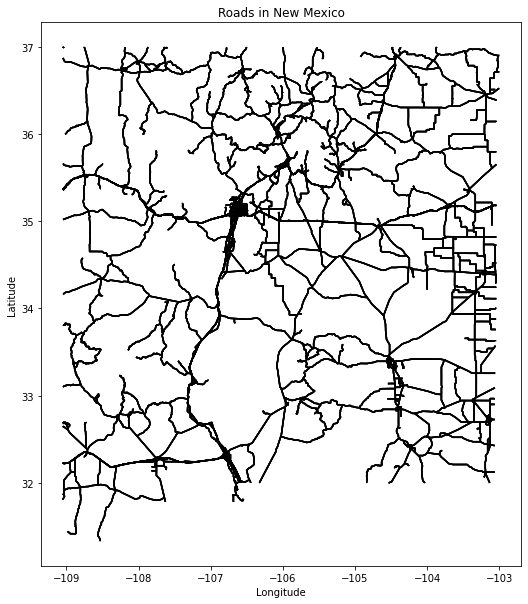

In [74]:
## ----- Add Pull and Plot from PostGIS Code Below -----------


# Define the SQL query to select road data
sql_query = """
SELECT id, road_name, road_type, road_length, coords
FROM jbazr6.new_mexico_roads
"""

# Load the data into a GeoDataFrame
gdf = gpd.read_postgis(sql_query, connection, geom_col='coords')

# Plot the road data
gdf.plot(edgecolor='black', figsize=(10, 10))
plt.title('Roads in New Mexico')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()








In [75]:
## ----- Add Save to Shapefile Code Below -----------


# Save the GeoDataFrame as an ESRI Shapefile
shapefile_path = '../temp/roads.shp'
gdf.to_file(shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile saved to {shapefile_path}")



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


Shapefile saved to ../temp/roads.shp


# Save Your Notebook
## Then Notebook Menu: File > Close and Halt

### Additional Resources
 * https://geohackweek.github.io/vector/03-encodings-libraries/